In [1]:
# delete this cell if working on Pycharm
!pip install Bio
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%bash

if [ ! -f NanoFoldLMReady ]; then
  # install dependencies
  pip -q install biopython
  pip install py3Dmol
  pip install pdb-tools


  # download model
  if [ ! -d "NanoNet/" ]; then
    git clone https://github.com/YaadLuria/NanoFoldLM --quiet
  fi
  touch NanoFoldLMReady
fi



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import torch
from tensorflow import keras
from keras import layers, saving
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path
%cd "/content/drive/MyDrive/Hackathon3D"
import import_ipynb
import utils

/content/drive/MyDrive/Hackathon3D
importing Jupyter notebook from utils.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
###############################################################################
#                                                                             #
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################


# number of ResNet blocks for the first ResNet and the kernel size.
RESNET_1_BLOCKS = 3
RESNET_1_KERNEL_SIZE = 15
RESNET_1_KERNEL_NUM = 128


###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 3
RESNET_2_KERNEL_SIZE = 3  # good start may be 3/5
RESNET_2_KERNEL_NUM = 128  # 128?
DILATION = [1, 2, 4, 8, 16]

# percentage of dropout for the dropout layer
DROPOUT = 0.3 # good start may be 0.1-0.5

# number of epochs, Learning rate and Batch size
EPOCHS = 150
LR = 0.0005 # good start may be 0.0001/0.001/0.01
BATCH = 64 # good start may be 32/64/128
OUTPUT_SIZE = 15
EMB_SIZE = 22

In [6]:
def resnet_1(input_layer):
    """
    ResNet layer - input -> BatchNormalization -> Conv1D -> Relu -> BatchNormalization -> Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_1_BLOCKS):
        batch_norm_layer = layers.BatchNormalization()(input_layer)
        conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same')(batch_norm_layer)
        batch_norm_layer = layers.BatchNormalization()(conv1d_layer)
        input_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same')(batch_norm_layer) + input_layer
    return input_layer


In [7]:
def resnet_2(input_layer):  # TODO: implement this!
    """
    Dilated ResNet layer - input -> BatchNormalization -> dilated Conv1D -> Relu -> BatchNormalization -> dilated Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_2_BLOCKS):
        for dil in DILATION:
            batch_norm_layer = layers.BatchNormalization()(input_layer)
            conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same', dilation_rate=dil)(batch_norm_layer)
            batch_norm_layer = layers.BatchNormalization()(conv1d_layer)
            input_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same', dilation_rate=dil)(batch_norm_layer) + input_layer
    return input_layer

In [8]:
def build_network():
    """
    builds the neural network architecture as shown in the exercise.
    :return: a Keras Model
    """
    # input, shape (NB_MAX_LENGTH,FEATURE_NUM)
    input_layer = tf.keras.Input(shape=(utils.NB_MAX_LENGTH, EMB_SIZE))

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(input_layer)

    # first ResNet -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    resnet_layer = resnet_1(conv1d_layer)

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, padding="same")(resnet_layer)

    # second ResNet -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    resnet_layer = resnet_2(conv1d_layer)

    # TODO: fill the missing layers
    dropout = layers.Dropout(DROPOUT)(resnet_layer)
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM/2, RESNET_2_KERNEL_SIZE, padding="same", activation='elu')(dropout)
    final = layers.Dense(OUTPUT_SIZE)(conv1d_layer)
    return tf.keras.Model(inputs=input_layer, outputs=final)



In [ ]:
def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 1, figsize=(15,3))
    axes.plot(history.history['loss'], label='Training loss')
    axes.plot(history.history['val_loss'], label='Validation loss')
    axes.legend()
    axes.set_title("Train and Val MSE loss")
    plt.savefig("/content/drive/MyDrive/Hackathon3D/Models/new_loss_" + str(EMB_SIZE))  # TODO: you can change the path here
    return [history.history['loss'], history.history['val_loss']]


Epoch 1/150
29/29 [==============================] - 56s 381ms/step - loss: 19.1674 - val_loss: 25.4632
Epoch 2/150
29/29 [==============================] - 7s 245ms/step - loss: 4.7387 - val_loss: 13.6711
Epoch 3/150
29/29 [==============================] - 7s 256ms/step - loss: 3.6443 - val_loss: 7.9331
Epoch 4/150
29/29 [==============================] - 7s 251ms/step - loss: 3.1481 - val_loss: 5.0114
Epoch 5/150
29/29 [==============================] - 7s 258ms/step - loss: 2.8443 - val_loss: 3.4331
Epoch 6/150
29/29 [==============================] - 7s 251ms/step - loss: 2.6113 - val_loss: 2.8777
Epoch 7/150
29/29 [==============================] - 8s 260ms/step - loss: 2.4071 - val_loss: 2.2100
Epoch 8/150
29/29 [==============================] - 7s 256ms/step - loss: 2.2789 - val_loss: 1.7690
Epoch 9/150
29/29 [==============================] - 8s 263ms/step - loss: 2.1510 - val_loss: 1.7724
Epoch 10/150
29/29 [==============================] - 8s 264ms/step - loss: 2.0620 - va

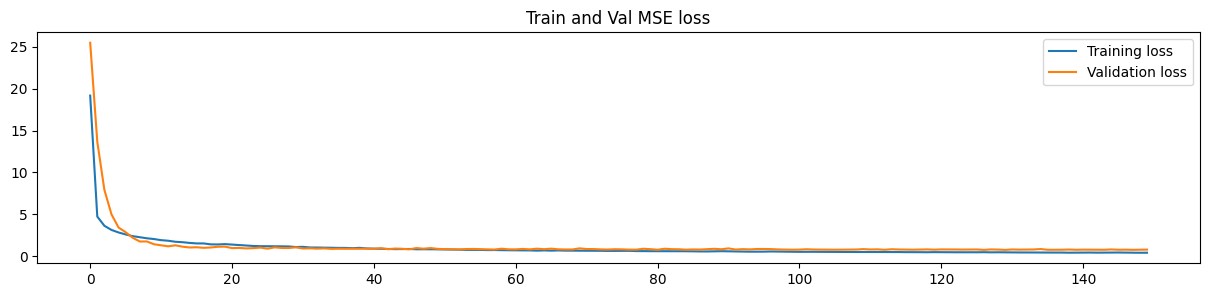

In [ ]:
if __name__ == '__main__':
  sizes = [500]
  X1 = np.load("/content/drive/MyDrive/Hackathon3D/Training_inputs_labels/train_input_1974_1280.npy")
  y1 = np.load("/content/drive/MyDrive/Hackathon3D/Training_inputs_labels/train_labels_1974_1280.npy")
  # X2 = np.load("/content/drive/MyDrive/Hackathon3D/Training_inputs_labels/train_input_one_hot.npy")
  # y2 = np.load("/content/drive/MyDrive/Hackathon3D/Training_inputs_labels/train_labels_one_hot.npy")

  for size in sizes:
    loss_list = []
    # ids = np.random.choice(1973, size, replace=False)
    # x1_samp = X1[ids]
    # y1_samp = y1[ids]
    # x2_samp = X2[ids]
    # y2_samp = y2[ids]

    save_callback = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Hackathon3D/Models/best_1280_model_new", save_best_only=True)
    EMB_SIZE = 1280
    model = build_network()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.MSE)
    hist = model.fit(x=X1, y=y1, batch_size=BATCH, epochs=EPOCHS,
                     validation_split=0.08)
    loss_list.append(plot_val_train_loss(hist))
    model.save("/content/drive/MyDrive/Hackathon3D/Models/biggest_model_" + str(EMB_SIZE) + ".tf", overwrite=True, save_format="tf")

#     EMB_SIZE = 22
#     model = build_network()
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.MSE)
#     hist = model.fit(x=x2_samp, y=y2_samp, batch_size=BATCH, epochs=EPOCHS, validation_split=0.08)
#     loss_list.append(plot_val_train_loss(hist))
#     plots = ["Embedding-640", "one-hot"]
# # log_loss = np.log(X)
#     colors = [["maroon", "indianred"],
#     ["darkgreen", "green"],
#     ["navy", "royalblue"],
#     ["purple","violet"],
#     ["dimgray", "silver"]]
#     ig, axes = plt.subplots(1, 1, figsize=(15,3))
#     for i in range(len(plots)):
#       axes.plot(loss_list[i][0],
#             label='Training loss ' + str(plots[i]),
#             color=colors[i][0])
#       axes.plot(loss_list[i][1],
#             label='Validation loss ' + str(plots[i]),
#             color=colors[i][1])
#     axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # axes.legend()
#     axes.set_title("Train and Validation MSE loss")
#     plt.savefig("/content/drive/MyDrive/Hackathon3D/Models/all_loss_150_" + str(size))
    # model.save("/content/drive/MyDrive/Hackathon3D/Models/short_model_" + str(EMB_SIZE) + ".tf", overwrite=True, save_format="tf")
  # for size in sizes:
  #   global EMB_SIZE
  #   EMB_SIZE = size
  #   model = build_network()
  #   X = np.load("/content/drive/MyDrive/Hackathon3D/Training_inputs_labels/train_input_1974_" + str(EMB_SIZE) + ".npy")
  #   y = np.load("/content/drive/MyDrive/Hackathon3D/Training_inputs_labels/train_labels_1974_" + str(EMB_SIZE) + ".npy")
  #   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.MSE)

  #   save_callback = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Hackathon3D/Models/best_" + str(EMB_SIZE) + "_model", save_best_only=True)
  #   hist = model.fit(x=X, y=y, batch_size=BATCH, epochs=EPOCHS, validation_split=0.08, callbacks=[save_callback])
  #   loss_list.append(plot_val_train_loss(hist))




    # model2 = keras.saving.load_model("./Ex4Files/predict/model1.tf")
    # X_pred = np.load("./Ex4Files/predict/train_input_6xw6.npy")
    # pred_data = model2.predict(X_pred)
    # seq_aa = get_seq_aa("./toPred/6xw6.pdb", "H")[0]
    # matrix_to_pdb(seq_aa, pred_data[0], "6xw6_new")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 1280)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 140, 128)     2457728     ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 140, 128)    512         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, 140, 128)     245888      ['batch_normalization[0][0]']

In [13]:
model2 = keras.models.load_model('/content/drive/MyDrive/Hackathon3D/Models/model_22.tf')
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 140, 22)]    0           []                               
                                                                                                  
 conv1d_243 (Conv1D)            (None, 140, 64)      21184       ['input_12[0][0]']               
                                                                                                  
 batch_normalization_212 (Batch  (None, 140, 64)     256         ['conv1d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d_244 (Conv1D)            (None, 140, 64)      61504       ['batch_normalization_212[0

In [ ]:
loss1=np.load("/content/drive/MyDrive/Hackathon3D/Models/loss_list.npy")
loss2 = np.append(loss1, np.asarray(loss_list), axis=0)
# loss1.append(np.asarray(loss_list))
np.save("/content/drive/MyDrive/Hackathon3D/Models/loss_list_with1hot.npy", np.array(loss2))
# np.save("/content/drive/MyDrive/Hackathon3D/Models/loss_list.npy", np.array(loss_list))

(4, 2, 150)
(1, 2, 150)
(5, 2, 150)


(5, 2, 150)


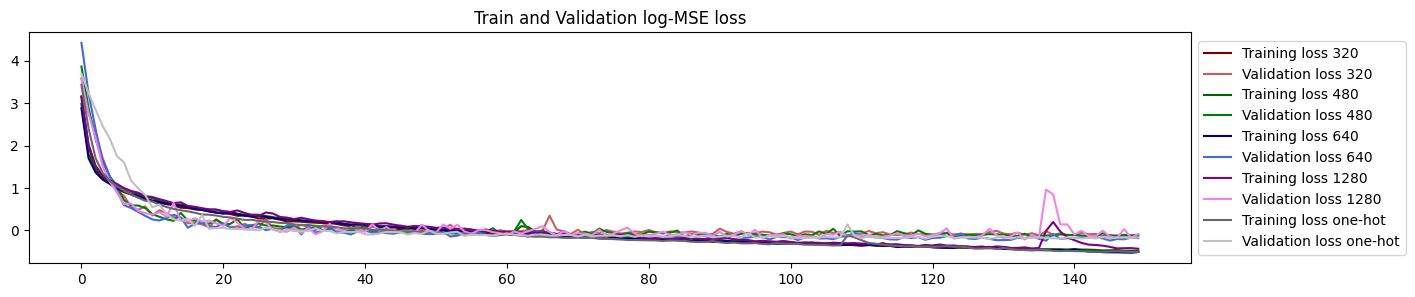

In [ ]:
X=np.load("/content/drive/MyDrive/Hackathon3D/Models/loss_list_with1hot.npy")
print(X.shape)
sizes = ["320", "480", "640", "1280", "one-hot"]
log_loss = np.log(X)
colors = [["maroon", "indianred"],
 ["darkgreen", "green"],
  ["navy", "royalblue"],
   ["purple","violet"],
          ["dimgray", "silver"]]
ig, axes = plt.subplots(1, 1, figsize=(15,3))
for i in range(len(sizes)):
  axes.plot(log_loss[i][0],
            label='Training loss ' + str(sizes[i]),
            color=colors[i][0])
  axes.plot(log_loss[i][1],
            label='Validation loss ' + str(sizes[i]),
            color=colors[i][1])
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes.legend()
axes.set_title("Train and Validation log-MSE loss")
plt.savefig("/content/drive/MyDrive/Hackathon3D/Models/all_loss_log")